<a href="https://colab.research.google.com/github/xelanac/metagenomic_project/blob/main/metagenomic_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import delle librerie

In [ ]:
%%capture
!pip3 install google-nucleus==0.4.0
!pip install -q tensorflow==2.0.0-alpha0

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

import numpy as np

from nucleus.io import fastq
from nucleus.io import fasta
from nucleus.io import sam
from nucleus.io import vcf
from nucleus.io.genomics_writer import TFRecordWriter
from nucleus.protos import reads_pb2
from nucleus.util import cigar
from nucleus.util import ranges
from nucleus.util import utils

import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Generazione di dataset randomici

In [ ]:
bases_list = ["A","C","G","T"]
seq_length = 30
seq_num = 20

dna_not_sanitized = []
dna_sanitized = []

In [ ]:
def random_seq_generation(n_seq, seq_len, dataset):
  for index in range(n_seq):
    sequence = [random.choice(bases_list) for _ in range(seq_len)]
    sequence = "".join(sequence)
    dataset.append(sequence)

In [ ]:
random_seq_generation(seq_num, seq_length, dna_not_sanitized)
random_seq_generation(seq_num, seq_length, dna_sanitized)

In [ ]:
"""
#creo il dataset non sanificato
for i in range(seq_num):
  sequence = [random.choice(bases_list) for _ in range(seq_length)]
  sequence = "".join(sequence)
  dna_not_sanitized.append(sequence)

#creo il dataset sanificato
for i in range(seq_num):
  sequence = [random.choice(bases_list) for _ in range(seq_length)]
  sequence = "".join(sequence)
  dna_sanitized.append(sequence)
"""

#Caricamento e analisi di dati reali (in questo caso trascurare la precedente sezione di generazione di dataset randomici)

Collegamento al drive e import dei dati reali

In [ ]:
#l'accesso al drive non è stato fatto attrsverso il codice, ma cliccando sull'icona della cartella drive
#riporto, sottoforma di commento, anche il codice per montarlo
"""
from google.colab import drive
drive.mount('/content/drive')
""" 
# Leggo il file grezzo fastq con la libreria
input_path_not_sanitized = "/content/drive/My Drive/fastQ_data/T0-R2-U1.R1.fastq"
input_path_sanitized = "/content/drive/My Drive/fastQ_data/T0-R2-U3.R1.fastq"

fastq_data_not_sanitized = fastq.FastqReader(input_path_not_sanitized)
fastq_data_sanitized = fastq.FastqReader(input_path_sanitized)

Visualizzazione del fastQ

In [ ]:
def read_fastq_structure(dataset):
  for i in dataset:
    print(i)
    break;

print("Dataset campionato prima dell'azione danificante: " , read_fastq_structure(dna_not_sanitized , "\n"))
print("Dataset campionato dopo l'azione danificante: ", read_fastq_structure(dna_sanitized, "\n"))

Funzione per l'isolamento delle sequenze


In [ ]:
# Definisco un metodo per la lettura di un record della libreria FASTQ
# Eventualmente rivediamo il metodo ora lo prendo per buono ma c'è qualcosa che non va
# Se lo lanci due volte sfalsa l'output

def seq_isolation(fastq_data, seq_list, single_record):
    seq_list.append(single_record)
    single_sequence = str(seq_list[0])
    single_record_list = single_sequence.split("\n") #lista contenente le proprietà di una singola sequenza(id, sequence, quality)

    fastq_sequence = single_record_list[2].split(" ") #2 è la posizione della sequenza
    final_sequence = fastq_sequence[1] #posizione nella nuova lista
    new_sequence = ""

    for i in final_sequence: #tolgo le "" dalla stringa
      if i != '"':
        new_sequence += i

    final_sequence = new_sequence
    #print(final_sequence)
    return final_sequence  

**Inizio dell'analisi dei dati**

In [ ]:
# Creo due liste contenenti rispettivamente le sequenze del dna campionate prima e dopo l'azione sanificante
fastq_data_list = []
dna_not_sanitized = []
dna_sanitized = []

for index in fastq_data_not_sanitized:
  dna_not_sanitized.append(seq_isolation(fastq_data_not_sanitized, fastq_data_list, index))

fastq_data_list = []

for index in fastq_data_sanitized:
  dna_not_sanitized.append(seq_isolation(fastq_data_not_sanitized, fastq_data_list, index))

# Stampo il numero di sequenze del dataset "not_sanitized"
len(dna_not_sanitized)
# Stampo il numero di sequenze del dataset "sanitized"
len(dna_sanitized)

Check sulla lunghezza delle sequenze

In [ ]:
#Lunghezza massima e minima del dataset "not_sanitized"
print("Lunghezza massima delle sequenze dna_not_sanitized: " , len(max(dna_not_sanitized, key=len)))
print("Lunghezza minima delle sequenze dna_not_sanitized: " , len(min(dna_not_sanitized, key=len)), "\n")

#Lunghezza massima e minima del dataset "sanitized"
print("Lunghezza massima delle sequenze dna_sanitized: " ,  len(max(dna_sanitized, key=len)))
print("Lunghezza minima delle sequenze dna_sanitized: " , len(min(dna_sanitized, key=len)))

Check che verifica se la sequenza ha qualche parametro "K", il quale indica un'imprecisione in fase di campionamento

In [ ]:
def sequences_check(sequences_list):
  i = 0

  for single_sequence in sequences_list:
    for index in single_sequence:
      if index == "K":
        return True
    i+= 1
  return False
  
print("Check delle sequenze non sanificate: \n", sequence_check(dna_not_sanitized))
print("Check delle sequenze  sanificate: \n", sequence_check(dna_sanitized))

Se la funzione "sequence_check" restituisce "True per una delle due liste, procedere con la correzione; altrimenti procedere con la creazione del vocabolario

In [ ]:
#con questo metodo sostituisco il parametro "k" con una delle basi azotate(in questo caso ho scelto l'Adenina)
def sequences_correction(sequences_list): 
  j = 0
  new_dna_sequence_list = []
  for single_sequence in sequences_list:
    i = 0
    new_sequence = ""
    for index in single_sequence:
      if index == "K":
        new_sequence+="A"
      else:
        new_sequence+=index
      i+=1
    new_dna_sequence_list.append(new_sequence)  
    j+=1     

  sequences_list = new_dna_sequence_list
  return sequences_list

In [ ]:
sequences_correction(dna_not_sanitized)
sequences_correctio(dna_sanitized)

#Creo il vocabolario

In [ ]:
%%capture
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
"""
vocab_size = 6
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, char_level=True, oov_token=oov_tok)

tokenizer.fit_on_texts(dna_sanitized)
vocab = tokenizer.word_index

print(vocab)
"""

'\nvocab_size = 6\noov_tok = "<OOV>"\n\ntokenizer = Tokenizer(num_words = vocab_size, char_level=True, oov_token=oov_tok)\n\ntokenizer.fit_on_texts(dna_sanitized)\nvocab = tokenizer.word_index\n\nprint(vocab)\n'

In [ ]:
tokenizer = Tokenizer(char_level=True)

tokenizer.fit_on_texts(dna_not_sanitized)

vocab = tokenizer.word_index
vocab_lenght = len(vocab) + 1

print("Vocabulary: " ,vocab)
type(vocab)

Vocabulary:  {'t': 1, 'c': 2, 'a': 3, 'g': 4}


dict

In [ ]:
input_not_sanitized = []

for line in dna_not_sanitized:
	token_list = tokenizer.texts_to_sequences([line])[0]
	#print(token_list)
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_not_sanitized.append(n_gram_sequence)

#pad sequences 
max_sequence_len = max([len(x) for x in input_not_sanitized])
input_sequences = np.array(pad_sequences(input_not_sanitized, maxlen=max_sequence_len, padding='pre'))

#xs, labels_x = input_sequences[:,:-1],input_sequences[:,-1] #il -1 omette l'ultimo carattere
xs = input_sequences[:,:-1] #il -1 omette l'ultimo carattere


In [ ]:
print(input_sequences)
print(input_sequences[:-1])

[[0 0 0 ... 0 1 3]
 [0 0 0 ... 1 3 3]
 [0 0 0 ... 3 3 1]
 ...
 [0 0 3 ... 3 2 2]
 [0 3 4 ... 2 2 4]
 [3 4 1 ... 2 4 4]]
[[0 0 0 ... 0 1 3]
 [0 0 0 ... 1 3 3]
 [0 0 0 ... 3 3 1]
 ...
 [0 0 0 ... 4 3 2]
 [0 0 3 ... 3 2 2]
 [0 3 4 ... 2 2 4]]


In [ ]:
input_sanitized = []

for line in dna_sanitized:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sanitized.append(n_gram_sequence)

#pad sequences
max_sequence_len = max([len(x) for x in input_sanitized])
input_sequences = np.array(pad_sequences(input_sanitized, maxlen=max_sequence_len, padding='pre'))

ys, labels_y = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels_y, num_classes=vocab_lenght)

In [ ]:
print("Dna not sanitized in pos 0:" , dna_not_sanitized[0])
print("Dna sanitized in pos 0:    " ,dna_sanitized[0])
print(vocab)

Dna not sanitized in pos 0: TAATTTGAGAGACGGGTCGAGGGCAGGAGG
Dna sanitized in pos 0:     AGCGAGCCGAATATCCCGTTTCAATTTCAG
{'t': 1, 'c': 2, 'a': 3, 'g': 4}


#Costruzione del modello Rnn con layer LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_lenght, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(vocab_lenght, activation='softmax'))

adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 100)           500       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 5)                 1505      
Total params: 303,205
Trainable params: 303,205
Non-trainable params: 0
_________________________________________________________________


In [ ]:
xs.shape

(1980, 99)

In [ ]:
history = model.fit(xs, ys, epochs=50, verbose=1)

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(ylabel="Accuratezza")
  plt.show()

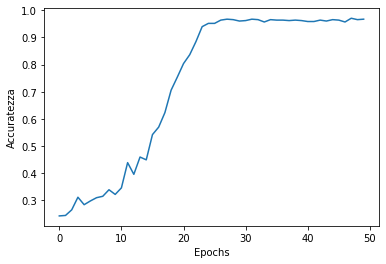

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
#genero metà sequenza di dna non sanificato
half_seq_length = int(seq_length / 2)
half_sequence = [random.choice(bases_list) for _ in range(half_seq_length)]
half_sequence = "".join(half_sequence)

print(half_sequence)

AACCAAGACCTTGAA


In [ ]:
def make_prediction(next_words, tokenizer, model, text_to_predict, j):
	for _ in range(next_words):
		token_list = tokenizer.texts_to_sequences([text_to_predict])[0]
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		predicted = model.predict_classes(token_list, verbose=0)
		output_word = ""
		for word, index in tokenizer.word_index.items():
			if index == predicted:
				output_word = word
				break
		text_to_predict += "" + output_word 
		j += "" + output_word 
		new_sequence = "".join(j) #isolo la nuova sequenza generata
	return new_sequence, text_to_predict

In [ ]:
text_to_predict = half_sequence
next_words = half_seq_length
new_sequence = []
increase_string = ""

new_sequence, text_to_predict = make_prediction(next_words, tokenizer, model, text_to_predict, increase_string)

print(text_to_predict) #concatenazione tra sequenza passata in input e la nuova generata
print(new_sequence)

AACCAAGACCTTGAAacactcagagacttg
acactcagagacttg


In [ ]:
def make_upper(text, index):
  s = ""
  for i in text:
    if i == "a":
      s = "A"
    if i == "c":
      s = "C"
    if i == "g":
      s = "G"
    if i == "t":
      s = "T"
    index += "" + s
    text = "".join(index)
  return text

In [ ]:
increase_sequence = ""
print(make_upper(new_sequence, increase_sequence))

ACACTCAGAGACTTG
